In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from jupyterthemes import jtplot

jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
print(tf.__version__)

2.6.0


In [44]:
df=pd.read_excel('appdata.xlsx')

In [25]:
# df=pd.read_csv('test_appdata.csv')

In [45]:
df.head()

,timeElapsed,x,y,z,label
0,0,9.38,-1.48,2.62,Sitting
1,1,9.37,-1.47,2.64,Sitting
2,2,9.39,-1.49,2.64,Sitting
3,3,9.37,-1.49,2.62,Sitting
4,4,9.38,-1.50,2.62,Sitting


In [46]:
df['label'].value_counts()

Walking       240200
Sitting       155436
Standing       98779
Upstairs       93248
Downstairs     62030
Name: label, dtype: int64

In [47]:
from sklearn.preprocessing import LabelEncoder

In [48]:
label = LabelEncoder()
df['ActivityLabel'] = label.fit_transform(df['label'])
df.tail()

,timeElapsed,x,y,z,label,ActivityLabel
649688,649688,3.30,-6.17,6.59,Downstairs,0
649689,649689,3.46,-5.95,6.61,Downstairs,0
649690,649690,3.42,-6.07,6.86,Downstairs,0
649691,649691,3.44,-6.13,7.10,Downstairs,0
649692,649692,3.43,-6.01,7.12,Downstairs,0


In [49]:
label.classes_



array(['Downstairs', 'Sitting', 'Standing', 'Upstairs', 'Walking'],
      dtype=object)

### Standardized data 

In [50]:
X = df[['x', 'y', 'z']]
y = df['ActivityLabel']

In [51]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['ActivityLabel'] = y.values

scaled_X

,x,y,z,ActivityLabel
0,1.482765,0.453011,0.512788,1
1,1.480515,0.454577,0.516259,1
2,1.485015,0.451446,0.516259,1
3,1.480515,0.451446,0.512788,1
4,1.482765,0.449880,0.512788,1
...,...,...,...,...
649688,0.114922,-0.281319,1.201840,0
649689,0.150917,-0.246873,1.205311,0
649690,0.141918,-0.265662,1.248702,0
649691,0.146418,-0.275056,1.290358,0


### Frame Preparation 

In [52]:
Fs = 50
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

In [53]:
def get_frames(df, frame_size, hop_size):
    N_FEATURES = 3
    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        # Retrieve the most often used label in this segment
        label = stats.mode(df['ActivityLabel'][i: i + frame_size])[0][0]

        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [54]:
X, y = get_frames(scaled_X, frame_size, hop_size)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

In [57]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 3, 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 3, 1)

In [58]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))


In [59]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [60]:
history = model.fit(X_train, y_train, epochs = 40, validation_data= (X_test, y_test), verbose=1)

Epoch 1/40
143/143 [==============================] - 2s 12ms/step - loss: 0.7795 - accuracy: 0.7132 - val_loss: 0.4881 - val_accuracy: 0.8061
Epoch 2/40
143/143 [==============================] - 2s 11ms/step - loss: 0.5514 - accuracy: 0.7860 - val_loss: 0.4794 - val_accuracy: 0.8235
Epoch 3/40
143/143 [==============================] - 2s 11ms/step - loss: 0.4962 - accuracy: 0.8014 - val_loss: 0.4116 - val_accuracy: 0.8261
Epoch 4/40
143/143 [==============================] - 2s 11ms/step - loss: 0.4420 - accuracy: 0.8242 - val_loss: 0.3954 - val_accuracy: 0.8240
Epoch 5/40
143/143 [==============================] - 2s 11ms/step - loss: 0.4244 - accuracy: 0.8251 - val_loss: 0.4043 - val_accuracy: 0.8307
Epoch 6/40
143/143 [==============================] - 2s 11ms/step - loss: 0.4094 - accuracy: 0.8366 - val_loss: 0.3890 - val_accuracy: 0.8338
Epoch 7/40
143/143 [==============================] - 2s 12ms/step - loss: 0.3830 - accuracy: 0.8405 - val_loss: 0.3681 - val_accuracy: 0.8399

In [61]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [62]:
pred = model.predict(X_test, batch_size = 32)
pred = np.argmax(pred, axis=1)

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x20c96b2c4f0>)

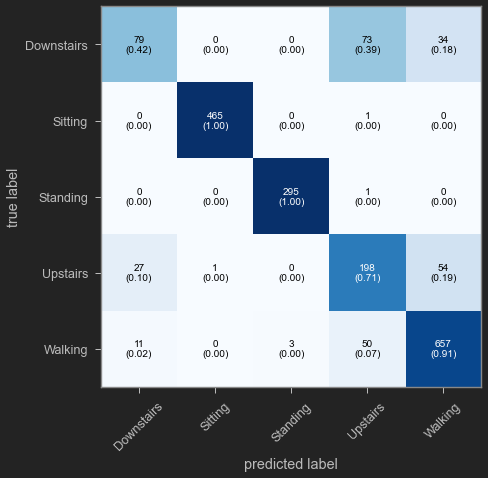

In [63]:
import seaborn as sns
mat = confusion_matrix(y_test, pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

In [64]:
score = model.evaluate(X_test, pred, verbose=0)
print("test loss, test acc:", score)

test loss, test acc: [0.1204179897904396, 1.0]
